In [9]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

## Definitions of climate indices

The definitions of these climate indices are taken from Defrance (2019). 

Defrance, D. (2019). Dataset of global extreme climatic indices due to an acceleration of ice sheet melting during the 21st century. Data in brief, 27, 104585. https://doi.org/10.1016/j.dib.2019.104585 

In [28]:
def PRCPTOT(da):
    # Calculate total wet-day precipitation
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    total_wetday_preciptation = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                PRCPTOT = sum(da_i.values)

                total_wetday_preciptation[lat, lon, year] = PRCPTOT
    
    return total_wetday_preciptation


def R1mm(da):
    # Calculate annual count of wet days
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_count_wetdays = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                wet_days = da_i.values > 1 # mm/day
                R1mm = np.sum(wet_days)

                annual_count_wetdays[lat, lon, year] = R1mm
    
    return annual_count_wetdays

def R10mm(da):
    # Calculate annual count of wet days when precipitation > 10 mm
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_count_wetdays_10mm = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                wet_days_10mm = da_i.values > 10 # mm/day
                R10mm = np.sum(wet_days_10mm)

                annual_count_wetdays_10mm[lat, lon, year] = R10mm
    
    return annual_count_wetdays_10mm

def R20mm(da):
    # Calculate annual count of wet days when precipitation > 20 mm
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_count_wetdays_20mm = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                wet_days_20mm = da_i.values > 20 # mm/day
                R20mm = np.sum(wet_days_20mm)

                annual_count_wetdays_20mm[lat, lon, year] = R20mm
    
    return annual_count_wetdays_20mm

def SDII(da):
    # Calculate simple precipitation intensity index
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    simple_precipitation_intensity = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                wet_days = da_i.values > 1 # # mm/day
                W = np.sum(wet_days)
                SDII = np.sum(da_i.values * wet_days)/W

                simple_precipitation_intensity[lat, lon, year] = SDII
    
    return simple_precipitation_intensity

def RX5day(da):
    # Calculate maximum consecutive 5-day precipitation
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    maximum_5day_precipitation = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                series = pd.Series(da_i.values)
                windows = series.rolling(5, min_periods=1) # Divide into five-day intervals
                RX5day = np.max(windows.sum()) # Find maximum five-day interval sum
                maximum_5day_precipitation[lat, lon, year] = RX5day
    
    return maximum_5day_precipitation

def CDD(da):
    # Calculate maximum length of dry spell
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    maximum_dry_spell = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                wet_days = da_i.values >= 1 # Find days when precipitation is larger than or equal to 1 mm/day
                wet_days_idx = np.where(wet_days)[0] # Find indexes of wet days
                if not list(wet_days_idx):
                    CDD = 365 # No wet days --> year long dry spell
                else:
                    CDD = int(np.max(np.diff([0]+list(wet_days_idx)+[364]))) # Find maximum difference between wet day indices, including endpoints
                maximum_dry_spell[lat, lon, year] = CDD
    
    return maximum_dry_spell

def CWD(da):
    # Calculate maximum length of wet spell
    # Input: daily precipitation amount
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    maximum_wet_spell = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                dry_days = da_i.values <= 1 # Find days when precipitation is less than or equal to 1 mm/day
                dry_days_idx = np.where(dry_days)[0] # Find indexes of dry days
                if not list(dry_days_idx):
                    CWD = 365 # No dry days --> year long wet spell
                else:
                    CWD = int(np.max(np.diff([0]+list(dry_days_idx)+[364]))) # Find maximum difference between dry day indices 

                maximum_wet_spell[lat, lon, year] = CWD
    
    return maximum_wet_spell       


## Loading relevant climate variables from different models, areas and time periods

CMIP6 data downloaded from https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/

In [ ]:
# User input

model_scenario_name = 'MRI-ESM2-0_ssp245' # Choose a model and SSP scenario
downscaled = True
area_name = 'norway' # Choose an area
save_folder = '../climatic_indices/' # Folder where climate indices should be saved


if downscaled==True:
    data_folder = '../NASA_data/' # Folder where downloaded downscaled CMIP6 data is stored
else:
    data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored

os.makedirs(save_folder, exist_ok=True) 

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'NorESM2-LM_ssp245':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'MRI-ESM2-0_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'MPI-ESM1-2-LR_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'GFDL-ESM4_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'europe':
    southern_lat = 35; northern_lat = 72
    western_lon = 310; eastern_lon = 33  
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

# Load daily precipitation flux

files = glob.glob(data_folder+'pr_day_'+model_scenario_name+'*')
files.sort()
pr = xr.open_mfdataset(files)

if area_name == 'europe':
    precip1 = pr.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, 360), 
                        time=slice(start_time, end_time))
    precip2 = pr.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(0, eastern_lon), 
                        time=slice(start_time, end_time))

    precip = xr.concat([precip1, precip2], dim='lon')
else:
    precip = pr.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

# Convert precipitation flux from kg/m2/s to daily amount --> mm/day

precip['pr'].values = precip.pr.values * 24*60*60
precip = precip.pr

Text(0.5, 1.0, 'Mean precipition')

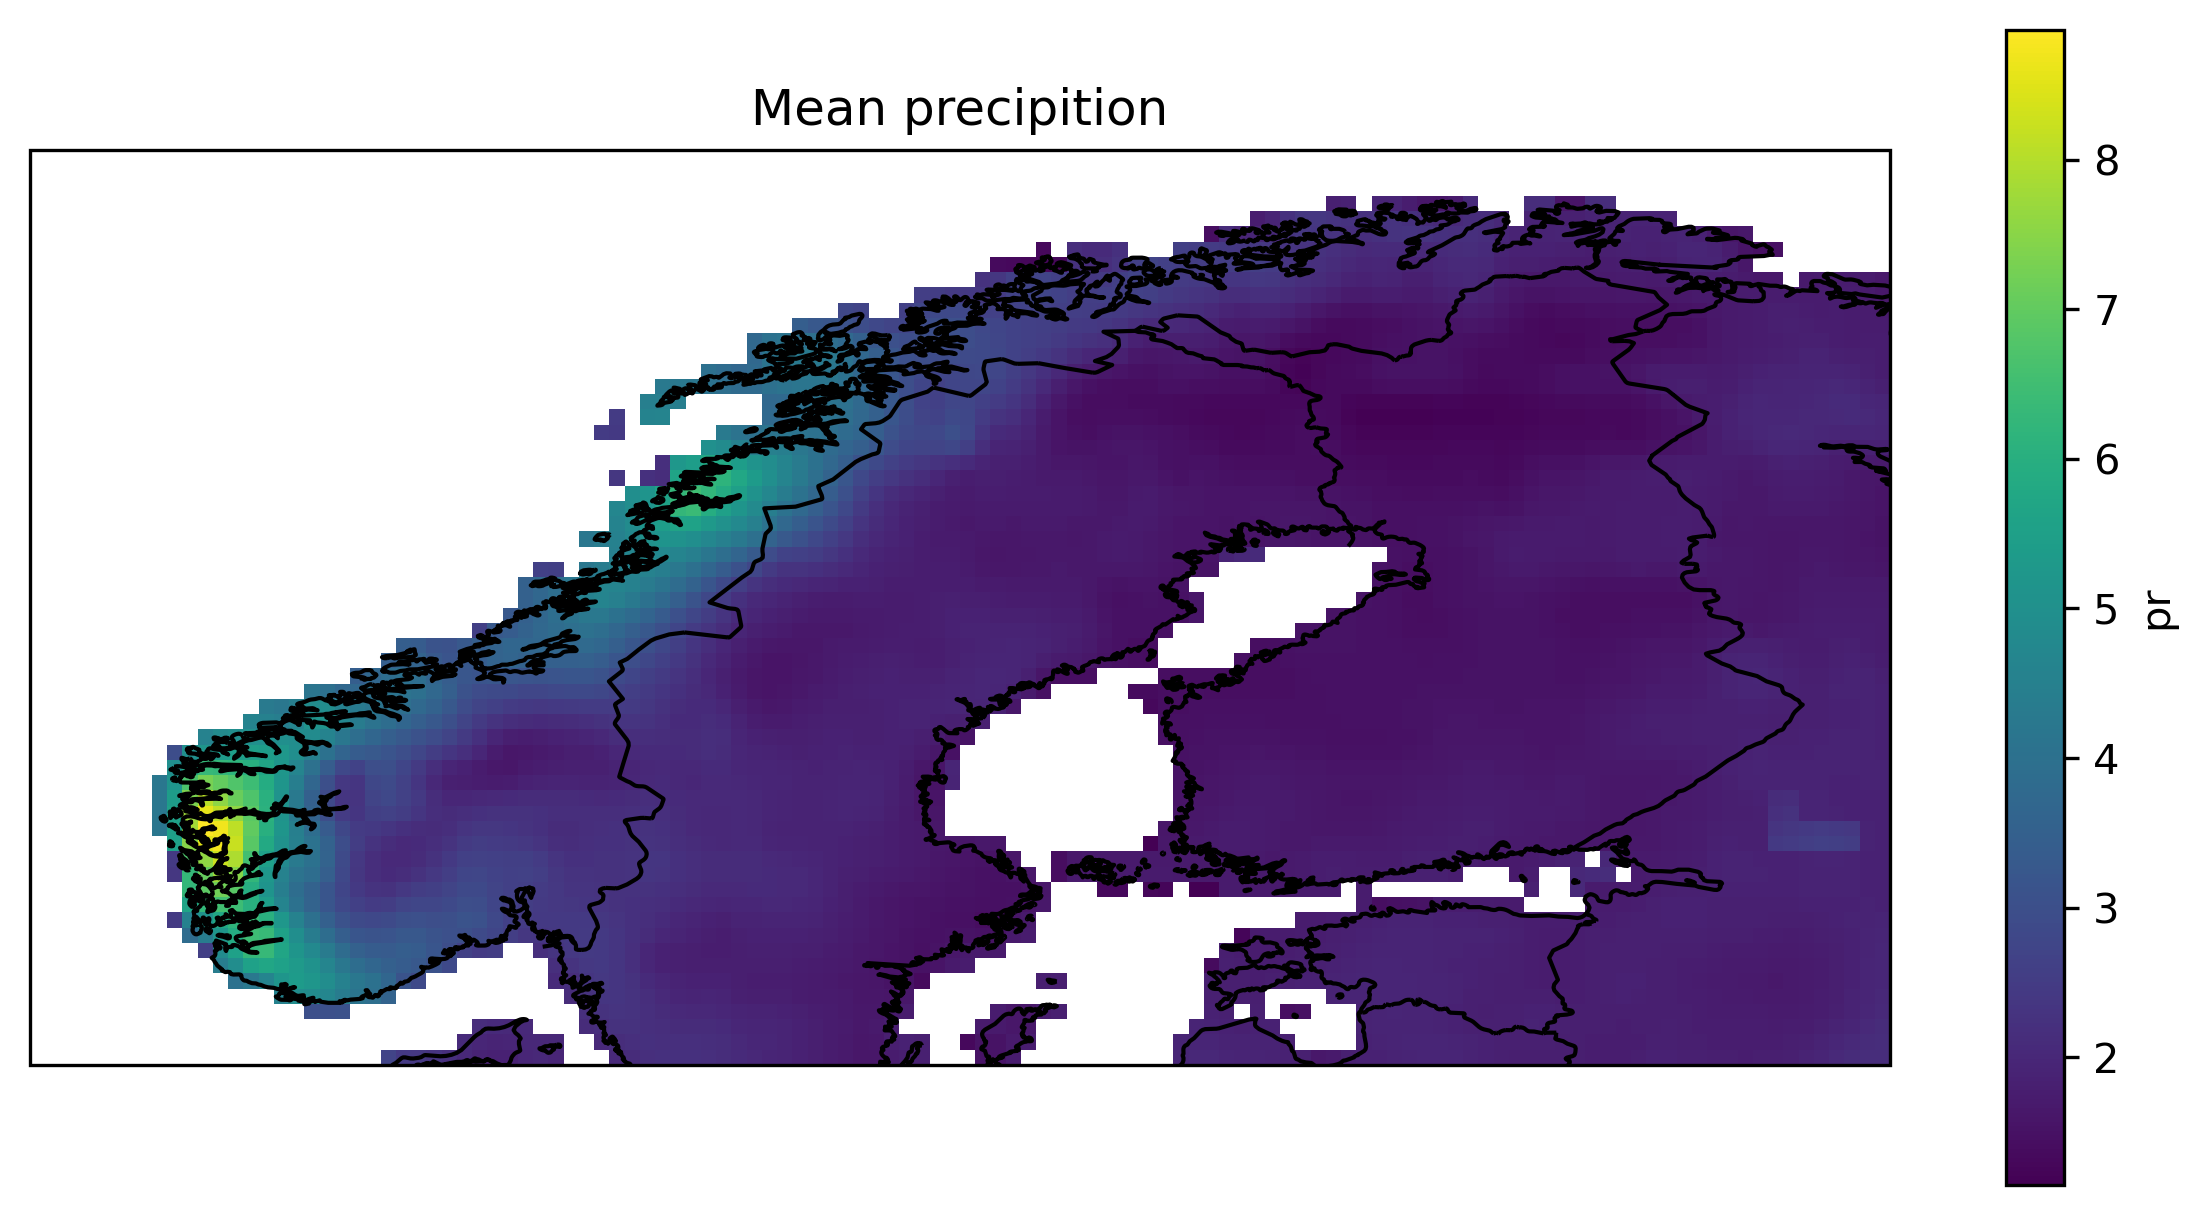

In [43]:
# Quick check of the mean precitation values in the dataset

import cartopy.feature as cFeature
precip_mean = precip.mean("time")
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
if area_name=='europe':
    precip_mean = precip_mean.reindex({'lon':pr.lon})
    ax.set_xlim([-50, 33])
map = precip_mean.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cFeature.BORDERS)
ax.set_title("Mean precipition")

## Calculate climatic indices

In [ ]:
# Choose which variable to calculate by creating new lists

variable_name_list = ['PRCPTOT', 'R1mm', 'R10mm', 'R20mm', 
                      'SDII', 'RX5day', 'CDD', 'CWD']
unit_list = ['mm', 'days', 'days', 'days', 'mm', 'mm', 'days', 'days']
description_list = ['Total wet-day precipitation', 'Annual count of wet days', 
                    'Annual count of wet days when precipitation > 10 mm', 
                    'Annual count of wet days when precipitation > 20 mm', 
                    'Simple precipitation intensity index', 'Maximum consecutive 5-day precipitation',
                    'Maximum length of dry spell', 'Maximum length of wet spell']
input_values = precip
index_function_list = [PRCPTOT, R1mm, R10mm, R20mm, 
                      SDII, RX5day, CDD, CWD]

# Save data as netcdf file

for variable_name, unit, description, index_function in zip(variable_name_list, unit_list, description_list, index_function_list):
    print(variable_name)
    values = index_function(input_values)
    
    ds = xr.Dataset(
        data_vars=dict(
            variable=(["lat", "lon", "time"], values)
        ),
        coords=dict(
            lat=input_values.lat.values,
            lon=input_values.lon.values,
            time=time_array,
        ),
    )

    ds.time.attrs['units'] = 'year'
    ds.lat.attrs['description'] = 'latitude'
    ds.lon.attrs['description'] = 'longitude'
    ds = ds.rename_vars(dict(variable=variable_name))
    ds[variable_name].attrs['units'] = unit
    ds[variable_name].attrs['description'] = description

    if downscaled==True:
        ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'_downscaled.nc')
    else:
        ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
   
    print('Dataset saved')

PRCPTOT
Dataset saved


### Check data with a quick plot

In [1]:
ds = xr.open_dataset(save_folder+'PRCPTOT_'+area_name+'_'+model_scenario_name+'.nc', decode_timedelta=False)
data = ds.PRCPTOT
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in annual precipitation")

NameError: name 'xr' is not defined